In [ ]:

!pip install -q --upgrade ultralytics numpy==1.24.3 scipy==1.11.4

import os
os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 58.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 49.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 30.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [13]:
!cp /kaggle/input/yolov8-sgd1/pytorch/default/1/best.pt /kaggle/working/models/best.pt

In [1]:
import os
from pathlib import Path
from datetime import datetime
import yaml
import shutil
from collections import defaultdict

import torch
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from IPython.display import display, HTML
import pandas as pd

# Görselleştirme ayarları
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: Tesla P100-PCIE-16GB


In [15]:
!ls /kaggle/working/data/datav2-folded

fold_1	fold_2	fold_3	fold_4	fold_5


In [21]:
BASE_DIR = Path("/kaggle/working")  # Colab için: Path("/content")
DATA_DIR = BASE_DIR / "data" / "datav2"
MODELS_DIR = BASE_DIR / "models"
RESULTS_DIR = BASE_DIR / "results"
RUNS_DIR = BASE_DIR / "runs"

for dir_path in [DATA_DIR, MODELS_DIR, RESULTS_DIR, RUNS_DIR]:
    dir_path.mkdir(exist_ok=True, parents=True)

# Eğitim konfigürasyonu
CONFIG = {
    'model_name': '/kaggle/working/models/best.pt',  # n, s, m, l, x
    'data_yaml': '/kaggle/working/data/datav2-folded/fold_1/data.yaml',
    'epochs': 30,
    'imgsz': 1248,
    'batch': 4,
    'patience': 20,
    'save_period': 10,
    'device': '0' if torch.cuda.is_available() else 'cpu',
    'workers': 2,
    'project_name': 'fold_1',
    'run_name': f"run_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
}

print("\n" + "="*70)
print("📋 Training Configuration:")
print("="*70)
for key, value in CONFIG.items():
    print(f"  {key:15s}: {value}")
print("="*70 + "\n")



📋 Training Configuration:
  model_name     : /kaggle/working/models/best.pt
  data_yaml      : /kaggle/working/data/datav2-folded/fold_1/data.yaml
  epochs         : 30
  imgsz          : 1248
  batch          : 4
  patience       : 20
  save_period    : 10
  device         : 0
  workers        : 2
  project_name   : fold_1
  run_name       : run_20251211_130934



In [4]:
!find /kaggle/input/data-v2/data_v2 -mindepth 1 -maxdepth 1 ! -name 'data.yaml' -exec cp -r {} /kaggle/working/data/datav2 \;

In [5]:
sample_data_yaml = """
path: /kaggle/working/data/datav2
train: train/images
val: valid/images
test: test/images

names:
- dentigeroz kist
- keratokist
- radikuler kist
- ameloblastoma
- odontoma
nc: 5
"""

# data.yaml kontrolü
data_yaml_path = Path(CONFIG['data_yaml'])
if not data_yaml_path.exists():
    print("⚠️  data.yaml bulunamadı. Örnek şablon oluşturuluyor...")
    with open(data_yaml_path, 'w') as f:
        f.write(sample_data_yaml)
    print(f"✅ Şablon oluşturuldu: {data_yaml_path}")
    print("🔧 Lütfen bu dosyayı veri setinize göre düzenleyin ve tekrar çalıştırın!")
else:
    print(f"✅ data.yaml bulundu: {data_yaml_path}\n")

⚠️  data.yaml bulunamadı. Örnek şablon oluşturuluyor...
✅ Şablon oluşturuldu: /kaggle/working/data/datav2/data.yaml
🔧 Lütfen bu dosyayı veri setinize göre düzenleyin ve tekrar çalıştırın!



📊 Dataset Statistics

TRAIN Set:
  Images: 453
  Labels: 453
  Total instances: 478
  Classes distribution:
    dentigeroz kist     :  105 ( 22.0%)
    keratokist          :   87 ( 18.2%)
    radikuler kist      :  227 ( 47.5%)
    ameloblastoma       :   24 (  5.0%)
    odontoma            :   35 (  7.3%)

VAL Set:
  Images: 97
  Labels: 97
  Total instances: 104
  Classes distribution:
    dentigeroz kist     :   23 ( 22.1%)
    keratokist          :   19 ( 18.3%)
    radikuler kist      :   50 ( 48.1%)
    ameloblastoma       :    5 (  4.8%)
    odontoma            :    7 (  6.7%)

TEST Set:
  Images: 98
  Labels: 98
  Total instances: 103
  Classes distribution:
    dentigeroz kist     :   24 ( 23.3%)
    keratokist          :   19 ( 18.4%)
    radikuler kist      :   48 ( 46.6%)
    ameloblastoma       :    5 (  4.9%)
    odontoma            :    7 (  6.8%)



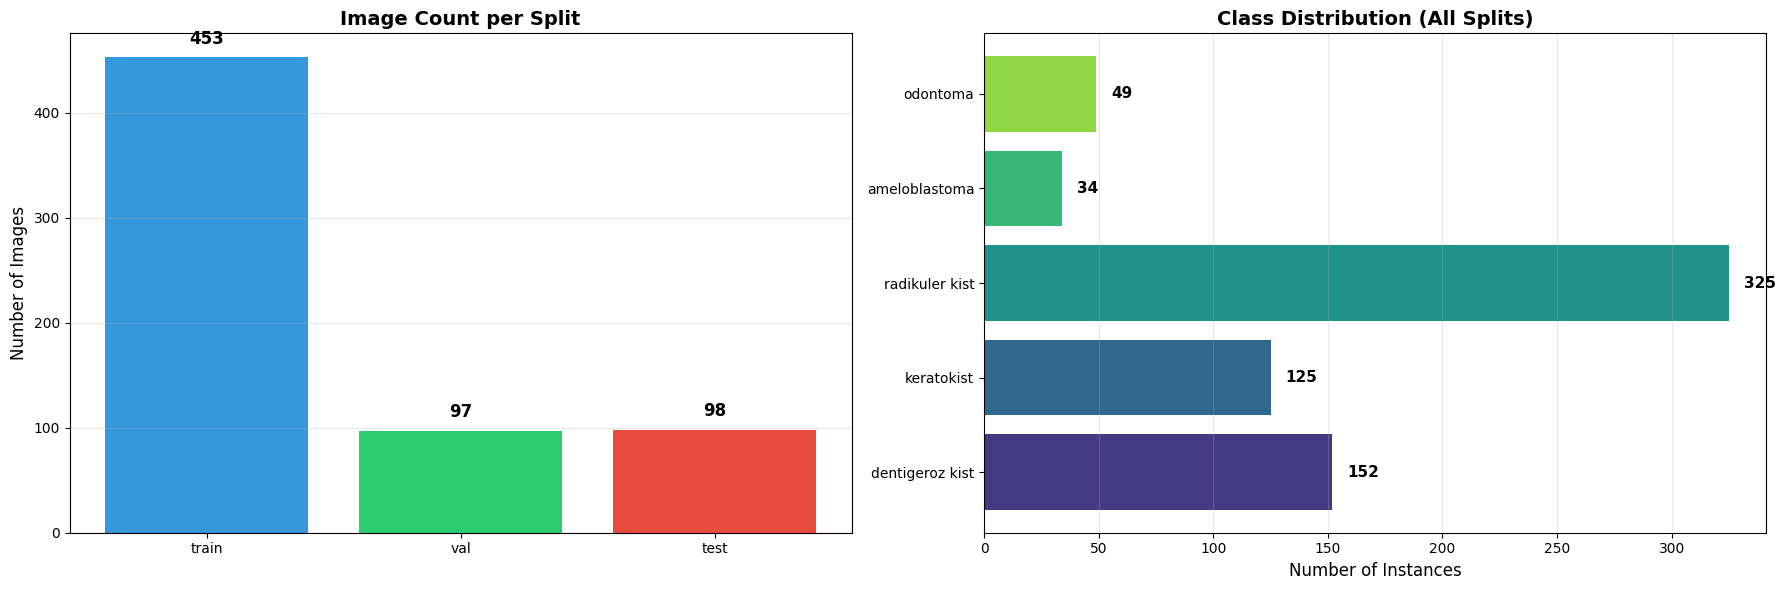

In [6]:
def analyze_dataset(data_yaml_path):
    """
    Veri seti istatistiklerini analiz et ve görselleştir
    """
    with open(data_yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)

    base_path = Path(data_config['path'])
    splits = ['train', 'val', 'test']

    print("\n" + "="*70)
    print("📊 Dataset Statistics")
    print("="*70 + "\n")

    # Her split için istatistikleri topla
    stats = {}
    for split in splits:
        if split not in data_config:
            continue

        img_dir = base_path / data_config[split]
        label_dir = base_path / data_config[split].replace('images', 'labels')

        images = list(img_dir.glob('*.jpg')) + list(img_dir.glob('*.png')) + list(img_dir.glob('*.jpeg')) + list(img_dir.glob('*.bmp'))
        labels = list(label_dir.glob('*.txt'))

        # Sınıf dağılımını analiz et
        class_counts = defaultdict(int)
        total_instances = 0

        for label_file in labels:
            with open(label_file, 'r') as f:
                for line in f:
                    if line.strip():
                        class_id = int(line.split()[0])
                        class_counts[class_id] += 1
                        total_instances += 1

        stats[split] = {
            'images': len(images),
            'labels': len(labels),
            'instances': total_instances,
            'class_counts': dict(class_counts)
        }

        print(f"{split.upper()} Set:")
        print(f"  Images: {len(images)}")
        print(f"  Labels: {len(labels)}")
        print(f"  Total instances: {total_instances}")
        print(f"  Classes distribution:")
        for class_id, count in sorted(class_counts.items()):
            class_name = data_config['names'][class_id]
            percentage = (count / total_instances * 100) if total_instances > 0 else 0
            print(f"    {class_name:20s}: {count:4d} ({percentage:5.1f}%)")
        print()

    # Görselleştirme
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Grafik 1: Her split'teki görüntü sayısı
    splits_present = [s for s in splits if s in stats]
    img_counts = [stats[s]['images'] for s in splits_present]

    axes[0].bar(splits_present, img_counts, color=['#3498db', '#2ecc71', '#e74c3c'])
    axes[0].set_title('Image Count per Split', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Number of Images', fontsize=12)
    axes[0].grid(axis='y', alpha=0.3)

    for i, (split, count) in enumerate(zip(splits_present, img_counts)):
        axes[0].text(i, count + max(img_counts)*0.02, str(count),
                    ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Grafik 2: Sınıf dağılımı (tüm split'ler birleşik)
    all_class_counts = defaultdict(int)
    for split_stats in stats.values():
        for class_id, count in split_stats['class_counts'].items():
            all_class_counts[class_id] += count

    class_names = [data_config['names'][cid] for cid in sorted(all_class_counts.keys())]
    class_counts_list = [all_class_counts[cid] for cid in sorted(all_class_counts.keys())]

    bars = axes[1].barh(class_names, class_counts_list, color=sns.color_palette("viridis", len(class_names)))
    axes[1].set_title('Class Distribution (All Splits)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Number of Instances', fontsize=12)
    axes[1].grid(axis='x', alpha=0.3)

    for i, (bar, count) in enumerate(zip(bars, class_counts_list)):
        axes[1].text(count + max(class_counts_list)*0.02, bar.get_y() + bar.get_height()/2,
                    str(count), va='center', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'dataset_statistics.png', dpi=150, bbox_inches='tight')
    plt.show()

    return data_config, stats

try:
    data_config, dataset_stats = analyze_dataset(data_yaml_path)
except Exception as e:
    print(f"⚠️  Dataset analizi yapılamadı: {e}")
    print("Lütfen data.yaml ve veri seti yapınızı kontrol edin.")

In [7]:
import os
import shutil
import yaml
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
import numpy as np
from collections import defaultdict

# Paths
BASE_PATH = Path("/kaggle/working/data/datav2")
OUTPUT_PATH = Path("/kaggle/working/data/datav2-folded")
TRAIN_IMAGES = BASE_PATH / "train/images"
TRAIN_LABELS = BASE_PATH / "train/labels"
VAL_IMAGES = BASE_PATH / "valid/images"
VAL_LABELS = BASE_PATH / "valid/labels"
TEST_IMAGES = BASE_PATH / "test/images"
TEST_LABELS = BASE_PATH / "test/labels"

# Class names
CLASS_NAMES = [
    'dentigeroz kist',
    'keratokist',
    'radikuler kist',
    'ameloblastoma',
    'odontoma'
]

def get_image_class(label_path):
    """Extract the primary class from a YOLO label file"""
    if not label_path.exists():
        return -1
    
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    if not lines:
        return -1
    
    # Get the first object's class (for stratification)
    first_line = lines[0].strip()
    if first_line:
        class_id = int(first_line.split()[0])
        return class_id
    return -1

def collect_dataset_info():
    """Combine TRAIN and VAL sets and collect their information"""
    print("Collecting dataset information...")
    
    combined_data = []
    
    # Collect TRAIN images
    for img_path in TRAIN_IMAGES.glob("*.*"):
        label_path = TRAIN_LABELS / f"{img_path.stem}.txt"
        class_id = get_image_class(label_path)
        combined_data.append({
            'image': img_path,
            'label': label_path,
            'class': class_id,
            'source': 'train'
        })
    
    # Collect VAL images
    for img_path in VAL_IMAGES.glob("*.*"):
        label_path = VAL_LABELS / f"{img_path.stem}.txt"
        class_id = get_image_class(label_path)
        combined_data.append({
            'image': img_path,
            'label': label_path,
            'class': class_id,
            'source': 'val'
        })
    
    print(f"Total images collected: {len(combined_data)}")
    
    # Print class distribution
    class_counts = defaultdict(int)
    for item in combined_data:
        class_counts[item['class']] += 1
    
    print("\nClass distribution:")
    for class_id, count in sorted(class_counts.items()):
        if class_id >= 0:
            print(f"  {CLASS_NAMES[class_id]}: {count}")
    
    return combined_data

def create_fold_structure(fold_idx):
    """Create directory structure for a specific fold"""
    fold_path = OUTPUT_PATH / f"fold_{fold_idx}"
    
    # Create directories
    (fold_path / "train/images").mkdir(parents=True, exist_ok=True)
    (fold_path / "train/labels").mkdir(parents=True, exist_ok=True)
    (fold_path / "val/images").mkdir(parents=True, exist_ok=True)
    (fold_path / "val/labels").mkdir(parents=True, exist_ok=True)
    
    return fold_path

def create_data_yaml(fold_path, fold_idx):
    """Create data.yaml file for a specific fold"""
    data_yaml = {
        'path': str(fold_path.absolute()),
        'train': 'train/images',
        'val': 'val/images',
        'test': str((BASE_PATH / 'test/images').absolute()),
        'nc': 5,
        'names': CLASS_NAMES
    }
    
    yaml_path = fold_path / "data.yaml"
    with open(yaml_path, 'w') as f:
        yaml.dump(data_yaml, f, default_flow_style=False, allow_unicode=True)
    
    print(f"  Created: {yaml_path}")
    return yaml_path

def copy_files(data_subset, dest_folder):
    """Copy images and labels to destination folder"""
    images_dest = dest_folder / "images"
    labels_dest = dest_folder / "labels"
    
    for item in data_subset:
        # Copy image
        img_dest = images_dest / item['image'].name
        shutil.copy2(item['image'], img_dest)
        
        # Copy label if exists
        if item['label'].exists():
            lbl_dest = labels_dest / item['label'].name
            shutil.copy2(item['label'], lbl_dest)

def create_5fold_splits():
    """Main function to create 5-fold cross-validation splits"""
    print("=" * 60)
    print("Creating 5-Fold Cross-Validation Dataset")
    print("=" * 60)
    
    # Collect combined dataset
    combined_data = collect_dataset_info()
    
    # Prepare data for stratified split
    X = np.arange(len(combined_data))
    y = np.array([item['class'] for item in combined_data])
    
    # Create stratified k-fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Create output directory
    OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
    
    print(f"\n{'=' * 60}")
    print("Creating folds...")
    print(f"{'=' * 60}\n")
    
    fold_stats = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"Processing Fold {fold_idx}...")
        
        # Create fold structure
        fold_path = create_fold_structure(fold_idx)
        
        # Split data
        train_data = [combined_data[i] for i in train_idx]
        val_data = [combined_data[i] for i in val_idx]
        
        # Copy files
        print(f"  Copying {len(train_data)} training images...")
        copy_files(train_data, fold_path / "train")
        
        print(f"  Copying {len(val_data)} validation images...")
        copy_files(val_data, fold_path / "val")
        
        # Create data.yaml
        create_data_yaml(fold_path, fold_idx)
        
        # Calculate statistics
        train_classes = defaultdict(int)
        val_classes = defaultdict(int)
        
        for item in train_data:
            if item['class'] >= 0:
                train_classes[item['class']] += 1
        
        for item in val_data:
            if item['class'] >= 0:
                val_classes[item['class']] += 1
        
        fold_stats.append({
            'fold': fold_idx,
            'train_count': len(train_data),
            'val_count': len(val_data),
            'train_classes': dict(train_classes),
            'val_classes': dict(val_classes)
        })
        
        print(f"  ✓ Fold {fold_idx} completed\n")
    
    # Print summary
    print(f"\n{'=' * 60}")
    print("SUMMARY")
    print(f"{'=' * 60}\n")
    
    for stats in fold_stats:
        print(f"Fold {stats['fold']}:")
        print(f"  Training:   {stats['train_count']} images")
        print(f"  Validation: {stats['val_count']} images")
        print(f"  Train class distribution:")
        for class_id, count in sorted(stats['train_classes'].items()):
            print(f"    {CLASS_NAMES[class_id]}: {count} ({count/stats['train_count']*100:.1f}%)")
        print(f"  Val class distribution:")
        for class_id, count in sorted(stats['val_classes'].items()):
            print(f"    {CLASS_NAMES[class_id]}: {count} ({count/stats['val_count']*100:.1f}%)")
        print()
    
    print(f"✓ All folds created successfully at: {OUTPUT_PATH}")
    print(f"✓ TEST set remains at: {BASE_PATH / 'test'}")
    
    return fold_stats

if __name__ == "__main__":
    fold_stats = create_5fold_splits()

Creating 5-Fold Cross-Validation Dataset
Total images collected: 550

Class distribution:
  dentigeroz kist: 126
  keratokist: 105
  radikuler kist: 249
  ameloblastoma: 29
  odontoma: 41

Creating folds...

Processing Fold 1...
  Copying 440 training images...
  Copying 110 validation images...
  Created: /kaggle/working/data/datav2-folded/fold_1/data.yaml
  ✓ Fold 1 completed

Processing Fold 2...
  Copying 440 training images...
  Copying 110 validation images...
  Created: /kaggle/working/data/datav2-folded/fold_2/data.yaml
  ✓ Fold 2 completed

Processing Fold 3...
  Copying 440 training images...
  Copying 110 validation images...
  Created: /kaggle/working/data/datav2-folded/fold_3/data.yaml
  ✓ Fold 3 completed

Processing Fold 4...
  Copying 440 training images...
  Copying 110 validation images...
  Created: /kaggle/working/data/datav2-folded/fold_4/data.yaml
  ✓ Fold 4 completed

Processing Fold 5...
  Copying 440 training images...
  Copying 110 validation images...
  Creat

In [22]:
def train_yolo_segmentation(config):
    """
    YOLO segmentation modelini eğit
    """
    print("\n" + "="*70)
    print(f"🚀 Training Started")
    print("="*70)
    print(f"Run name: {config['run_name']}")
    print(f"Model: {config['model_name']}")
    print(f"Device: {config['device']}")
    print(f"Epochs: {config['epochs']}")
    print(f"Batch size: {config['batch']}")
    print(f"Image size: {config['imgsz']}")
    print("="*70 + "\n")

    # Model yükle
    model = YOLO(config['model_name'])

    # Run directory
    project_dir = RUNS_DIR / config['project_name']

    # Eğitim parametreleri
    train_args = {
        'data': config['data_yaml'],
        'epochs': config['epochs'],
        'imgsz': config['imgsz'],
        'batch': config['batch'],
        'device': config['device'],
        'patience': config['patience'],
        'save': True,
        'save_period': config['save_period'],
        'project': str(project_dir),
        'name': config['run_name'],
        'exist_ok': True,
        'pretrained': True,
        'seed': 42,

        # sgd - 1
        'optimizer': 'SGD',
        'lr0': 0.01,
        'momentum': 0.90,
        'weight_decay': 1e-4,
        'cos_lr': True,
        'warmup_epochs': 3,
        'warmup_momentum': 0.8,
        'warmup_bias_lr': 0.05,

        'auto_augment': None,
        'plots': True,
        'verbose': True,
        'cache': 'ram',
        'workers': config['workers'],
        'amp': True,
        'freeze': 0,
        'deterministic': True, 

        'degrees':0.0,        # Rotasyon yok
        'translate':0.05,     # Çok hafif kaydırma
        'scale':0.2,          # Çok hafif zoom
        'fliplr':0.5,         # Sadece yatay flip
        'flipud':0.0,         # Dikey flip yok
        'hsv_v':0.2,          # Hafif brightness değişimi
        'mosaic':0.0,         # Kapalı
        'mixup':0.0,          # Kapalı

        
        
    }

    results = model.train(**train_args)

    # Model yolları
    run_dir = project_dir / config['run_name']
    best_model_path = run_dir / 'weights' / 'best.pt'
    last_model_path = run_dir / 'weights' / 'last.pt'

    print("\n" + "="*70)
    print(f"✅ Training Completed!")
    print("="*70)
    print(f"📁 Results directory: {run_dir}")
    print(f"🏆 Best model: {best_model_path}")
    print(f"🔄 Last model: {last_model_path}")
    print("="*70 + "\n")

    return results, best_model_path, run_dir

In [ ]:

try:
    training_results, best_model_path, run_dir = train_yolo_segmentation(CONFIG)
except Exception as e:
    print(f"❌ Training error: {e}")
    raise


🚀 Training Started
Run name: run_20251211_130934
Model: /kaggle/working/models/best.pt
Device: 0
Epochs: 30
Batch size: 4
Image size: 1248

New https://pypi.org/project/ultralytics/8.3.236 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=None, batch=4, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/data/datav2-folded/fold_1/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.2, imgsz=1248, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.0